In [1]:
import zipfile
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print (session.run(c))

[[22. 28.]
 [49. 64.]]


In [2]:
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import *
from keras.regularizers import *
import time
import pickle
import matplotlib.pyplot as plt
import keras.backend as K
from skimage.io import imread
from skimage.transform import resize

from keras.applications.densenet import DenseNet201, preprocess_input

Using TensorFlow backend.


In [9]:
del(encoder)
del(decoder)
del(vae)

In [15]:
# VAE model = encoder + decoder
# build encoder model
latent_dim = (18,18,64)
input_shape=(18,18,736)

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

inputs = Input(shape=input_shape, name='encoder_input')

x = Dense(512, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)

z_mean = Dense(64, name='z_mean')(x)
z_log_var = Dense(64, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim), name='z_sampling')

x = Dense(128, activation='relu')(latent_inputs)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(736, activation='sigmoid')(x)
outputs = BatchNormalization()(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

def vae_loss(z_mean=z_mean,z_log_var=z_log_var):
    def loss(inputs, outputs):
        xent_loss = binary_crossentropy(inputs, outputs)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - 
                    K.exp(z_log_var), axis=-1)
        return  xent_loss+kl_loss
    return loss

vae.compile(optimizer='adam', loss=vae_loss(z_mean, z_log_var))

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 18, 18, 512)  377344      encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 18, 18, 512)  2048        dense_22[0][0]                   
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 18, 18, 256)  131328      batch_normalization_22[0][0]     
____________________________________________________________________________________________

In [6]:
vae_loss

<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

In [24]:
import os
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/tf/data/Quan/datasets/amazon'
train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(300,300), 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

validation_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=batch_size, 
                                                        shuffle=False)

test_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

label_dict = test_generator.class_indices

Found 1576 images belonging to 31 classes.
Found 395 images belonging to 31 classes.
Found 846 images belonging to 31 classes.


In [12]:
with open('/tf/data/Quan/tf_models/amazon/extracted_features.hdf5', 'rb') as dt:
    s_labels, s_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/amazon/val_extracted_features.hdf5', 'rb') as dt:
    sval_labels, sval_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/webcam/extracted_features.hdf5', 'rb') as dt:
    t_labels, t_features = pickle.load(dt)
    
with open('/tf/data/Quan/tf_models/webcam/val_extracted_features.hdf5', 'rb') as dt:
    tval_labels, tval_features = pickle.load(dt)

with open('/tf/data/Quan/tf_models/webcam/t_test_features.hdf5', 'rb') as dt:
    ttest_labels, ttest_features = pickle.load(dt)

# s_labels = [k.split('/')[-2] for k in s_labels]
# sval_labels = [k.split('/')[-2] for k in sval_labels]

t_labels = [k.split('/')[-2] for k in t_labels]
tval_labels = [k.split('/')[-2] for k in tval_labels]
    
# s_features.shape, sval_features.shape, t_features.shape

## Amazon

In [13]:
batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/amazon/vae_p36_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(s_features, s_features, batch_size=batch_size, epochs=100, 
          validation_data=(sval_features, sval_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/amazon/vae_p36_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1576 samples, validate on 395 samples
Epoch 1/100
1576/1576 [==============================] - 5s 3ms/step - loss: 5.2281 - val_loss: 3.1610
Epoch 2/100
1576/1576 [==============================] - 3s 2ms/step - loss: 2.4739 - val_loss: 1.3293
Epoch 3/100
1576/1576 [==============================] - 3s 2ms/step - loss: 1.2449 - val_loss: 0.3992
Epoch 4/100
1576/1576 [==============================] - 3s 2ms/step - loss: 0.5767 - val_loss: -0.0970
Epoch 5/100
1576/1576 [==============================] - 3s 2ms/step - loss: 0.0968 - val_loss: -0.4475
Epoch 6/100
1576/1576 [==============================] - 3s 2ms/step - loss: -0.1798 - val_loss: -0.6088
Epoch 7/100
1576/1576 [==============================] - 3s 2ms/step - loss: -0.4809 - val_loss: -0.8536
Epoch 8/100
1576/1576 [==============================] - 3s 2ms/step - loss: -0.6873 - val_loss: -0.9874
Epoch 9/100
1576/1576 [===

1576/1576 [==============================] - 4s 2ms/step - loss: -2.1461 - val_loss: -2.3543
Epoch 74/100
1576/1576 [==============================] - 4s 2ms/step - loss: -2.1464 - val_loss: -2.3600
Epoch 75/100
1576/1576 [==============================] - 4s 2ms/step - loss: -2.1666 - val_loss: -2.3839
Epoch 76/100
1576/1576 [==============================] - 4s 2ms/step - loss: -2.1745 - val_loss: -2.3761
Epoch 77/100
1576/1576 [==============================] - 4s 2ms/step - loss: -2.2144 - val_loss: -2.4872
Epoch 78/100
1576/1576 [==============================] - 4s 2ms/step - loss: -2.2627 - val_loss: -2.4847
Epoch 79/100
1576/1576 [==============================] - 4s 2ms/step - loss: -2.2812 - val_loss: -2.4781
Epoch 80/100
1576/1576 [==============================] - 4s 2ms/step - loss: -2.2767 - val_loss: -2.4879
Epoch 81/100
1576/1576 [==============================] - 4s 2ms/step - loss: -2.2470 - val_loss: -2.4695
Epoch 82/100
1576/1576 [==============================] - 4

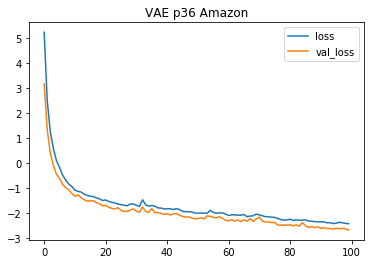

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('VAE p36 Amazon')
plt.show()

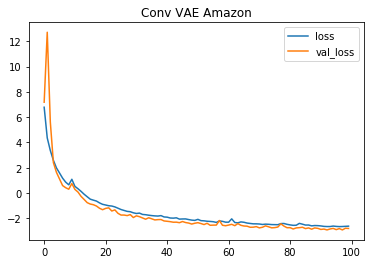

In [7]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Conv VAE Amazon')
plt.show()

## Webcam

In [16]:
batch_size=32
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam/vae_p36_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(t_features, t_features, batch_size=batch_size, epochs=100, 
          validation_data=(tval_features, tval_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/tf/data/Quan/tf_models/webcam/vae_p36_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 2s 4ms/step - loss: 6.3606 - val_loss: 1.3798
Epoch 2/100
444/444 [==============================] - 1s 2ms/step - loss: 5.7326 - val_loss: 1.6559
Epoch 3/100
444/444 [==============================] - 1s 2ms/step - loss: 5.1000 - val_loss: 1.6798
Epoch 4/100
444/444 [==============================] - 1s 2ms/step - loss: 4.6053 - val_loss: 1.6413
Epoch 5/100
444/444 [==============================] - 1s 2ms/step - loss: 4.2075 - val_loss: 2.1225
Epoch 6/100
444/444 [==============================] - 1s 2ms/step - loss: 3.8945 - val_loss: 1.7025
Epoch 7/100
444/444 [==============================] - 1s 2ms/step - loss: 3.5270 - val_loss: 1.6565
Epoch 8/100
444/444 [==============================] - 1s 2ms/step - loss: 3.2730 - val_loss: 1.7298
Epoch 9/100
444/444 [==============================] - 1s 2ms/step - loss: 3.0010 - val_loss: 1.6730
Epoch 10/100
444/444 [=======================

444/444 [==============================] - 1s 2ms/step - loss: -0.1946 - val_loss: -0.2658
Epoch 81/100
444/444 [==============================] - 1s 2ms/step - loss: -0.2063 - val_loss: -0.2352
Epoch 82/100
444/444 [==============================] - 1s 2ms/step - loss: -0.1886 - val_loss: -0.1726
Epoch 83/100
444/444 [==============================] - 1s 2ms/step - loss: -0.1851 - val_loss: -0.1891
Epoch 84/100
444/444 [==============================] - 1s 2ms/step - loss: -0.1804 - val_loss: -0.1999
Epoch 85/100
444/444 [==============================] - 1s 2ms/step - loss: -0.1966 - val_loss: -0.2704
Epoch 86/100
444/444 [==============================] - 1s 2ms/step - loss: -0.2096 - val_loss: -0.2512
Epoch 87/100
444/444 [==============================] - 1s 2ms/step - loss: -0.2217 - val_loss: -0.2408
Epoch 88/100
444/444 [==============================] - 1s 2ms/step - loss: -0.2027 - val_loss: -0.2038
Epoch 89/100
444/444 [==============================] - 1s 2ms/step - loss: -

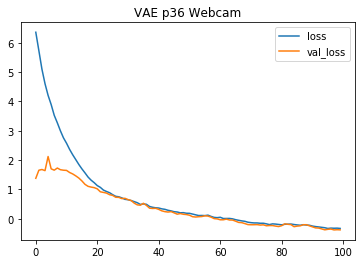

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('VAE p36 Webcam')
plt.show()

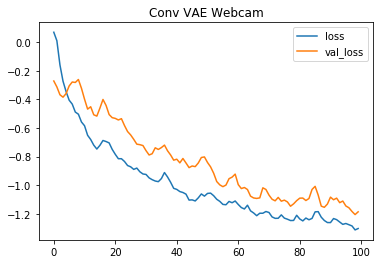

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Conv VAE Webcam')
plt.show()

## Combine VAE

In [18]:
import keras.losses
keras.losses.vae_loss = vae_loss

s_vae = load_model('/tf/data/Quan/tf_models/amazon/vae_p36_model.hdf5',custom_objects={'latent_dim': latent_dim, 'loss': vae_loss(z_mean,z_log_var)})
t_vae = load_model('/tf/data/Quan/tf_models/webcam/vae_p36_model.hdf5',custom_objects={'latent_dim': latent_dim, 'loss': vae_loss(z_mean,z_log_var)})

s_vae.summary()
t_vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
encoder (Model)              [(None, 18, 18, 64), (Non 561664    
_________________________________________________________________
decoder (Model)              (None, 18, 18, 736)       557024    
Total params: 1,118,688
Trainable params: 1,113,632
Non-trainable params: 5,056
_________________________________________________________________
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
encoder (Model)              [(None, 18, 18, 64), (Non 561664    
____________________________________

In [19]:
t_encoder = Model(t_vae.get_layer('encoder').inputs, t_vae.get_layer('encoder').outputs, name='t_encoder')
s_decoder = Model(s_vae.get_layer('decoder').inputs, s_vae.get_layer('decoder').outputs, name='s_decoder')

t_encoder.summary()

Model: "t_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 18, 18, 512)  377344      encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 18, 18, 512)  2048        dense_22[0][0]                   
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 18, 18, 256)  131328      batch_normalization_22[0][0]     
__________________________________________________________________________________________

In [20]:
c_vae_outputs = s_decoder(t_encoder(t_encoder.inputs)[2])
c_vae = Model(t_encoder.inputs, c_vae_outputs, name='combined_vae')
c_vae.summary()

Model: "combined_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
t_encoder (Model)            [(None, 18, 18, 64), (Non 561664    
_________________________________________________________________
s_decoder (Model)            (None, 18, 18, 736)       557024    
Total params: 1,118,688
Trainable params: 1,113,632
Non-trainable params: 5,056
_________________________________________________________________


In [25]:
t_num_labels = [label_dict[k] for k in t_labels]
tval_num_labels = [label_dict[k] for k in tval_labels]
ttest_num_labels = [label_dict[k] for k in ttest_labels]

t_num_labels = keras.utils.to_categorical(t_num_labels, 31)
tval_num_labels = keras.utils.to_categorical(tval_num_labels, 31)
ttest_num_labels = keras.utils.to_categorical(ttest_num_labels, 31)

transform_features = c_vae.predict(t_features, verbose=1)
val_transform_features = c_vae.predict(tval_features, verbose=1)
test_transform_features = c_vae.predict(ttest_features, verbose=1)

239/239 [==============================] - 0s 1ms/step


In [26]:
# retrain source classifier


input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)


s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
s_topmodel.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 18, 18, 736)       0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 736)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 31)                22847     
_________________________________________________________________
batch_normalization_30 (Batc (None, 31)                124       
_________________________________________________________________
activation_2 (Activation)    (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
______________________________________________________

In [27]:
mcp = ModelCheckpoint('/tf/data/Quan/tf_models/webcam/amazon_vae_classifier_scratch_model.hdf5', monitor='val_accuracy', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transform_features, t_num_labels, batch_size=32, epochs=200,
               validation_data=(val_transform_features, tval_num_labels), verbose=1, callbacks=[mcp])

with open('/tf/data/Quan/tf_models/webcam/amazon_vae_classifier_scratch_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/200
444/444 [==============================] - 1s 2ms/step - loss: 3.6359 - accuracy: 0.0653 - val_loss: 3.4974 - val_accuracy: 0.0714
Epoch 2/200
444/444 [==============================] - 0s 458us/step - loss: 3.3542 - accuracy: 0.0833 - val_loss: 3.2835 - val_accuracy: 0.1071
Epoch 3/200
444/444 [==============================] - 0s 458us/step - loss: 3.0553 - accuracy: 0.1171 - val_loss: 3.0983 - val_accuracy: 0.0982
Epoch 4/200
444/444 [==============================] - 0s 470us/step - loss: 2.8298 - accuracy: 0.1959 - val_loss: 2.9273 - val_accuracy: 0.0982
Epoch 5/200
444/444 [==============================] - 0s 454us/step - loss: 2.7093 - accuracy: 0.2095 - val_loss: 2.7847 - val_accuracy: 0.1339
Epoch 6/200
444/444 [==============================] - 0s 469us/step - loss: 2.5782 - accuracy: 0.2905 - val_loss: 2.6618 - val_accuracy: 0.2232
Epoch 7/200
444/444 [==============================] - 0s 467us/step - loss: 2.4886 - 

Epoch 57/200
444/444 [==============================] - 0s 494us/step - loss: 1.4231 - accuracy: 0.7365 - val_loss: 1.5860 - val_accuracy: 0.6875
Epoch 58/200
444/444 [==============================] - 0s 469us/step - loss: 1.3687 - accuracy: 0.7613 - val_loss: 1.5840 - val_accuracy: 0.6964
Epoch 59/200
444/444 [==============================] - 0s 465us/step - loss: 1.4092 - accuracy: 0.7455 - val_loss: 1.5761 - val_accuracy: 0.7054
Epoch 60/200
444/444 [==============================] - 0s 472us/step - loss: 1.3803 - accuracy: 0.7703 - val_loss: 1.5717 - val_accuracy: 0.7054
Epoch 61/200
444/444 [==============================] - 0s 481us/step - loss: 1.3556 - accuracy: 0.7590 - val_loss: 1.5645 - val_accuracy: 0.7143
Epoch 62/200
444/444 [==============================] - 0s 466us/step - loss: 1.3745 - accuracy: 0.7568 - val_loss: 1.5547 - val_accuracy: 0.7054
Epoch 63/200
444/444 [==============================] - 0s 471us/step - loss: 1.3471 - accuracy: 0.7973 - val_loss: 1.5524 -

444/444 [==============================] - 0s 464us/step - loss: 1.0690 - accuracy: 0.8018 - val_loss: 1.3122 - val_accuracy: 0.7500
Epoch 114/200
444/444 [==============================] - 0s 471us/step - loss: 1.0751 - accuracy: 0.8311 - val_loss: 1.3127 - val_accuracy: 0.7500
Epoch 115/200
444/444 [==============================] - 0s 493us/step - loss: 1.0387 - accuracy: 0.8311 - val_loss: 1.3102 - val_accuracy: 0.7589
Epoch 116/200
444/444 [==============================] - 0s 454us/step - loss: 1.0505 - accuracy: 0.8131 - val_loss: 1.3110 - val_accuracy: 0.7589
Epoch 117/200
444/444 [==============================] - 0s 506us/step - loss: 1.0536 - accuracy: 0.8198 - val_loss: 1.3080 - val_accuracy: 0.7500
Epoch 118/200
444/444 [==============================] - 0s 487us/step - loss: 1.0438 - accuracy: 0.8243 - val_loss: 1.3073 - val_accuracy: 0.7500
Epoch 119/200
444/444 [==============================] - 0s 463us/step - loss: 1.0782 - accuracy: 0.8063 - val_loss: 1.2989 - val_ac

Epoch 169/200
444/444 [==============================] - 0s 469us/step - loss: 0.9250 - accuracy: 0.8198 - val_loss: 1.1581 - val_accuracy: 0.7589
Epoch 170/200
444/444 [==============================] - 0s 509us/step - loss: 0.9110 - accuracy: 0.8243 - val_loss: 1.1471 - val_accuracy: 0.7589
Epoch 171/200
444/444 [==============================] - 0s 455us/step - loss: 0.8917 - accuracy: 0.8446 - val_loss: 1.1442 - val_accuracy: 0.7589
Epoch 172/200
444/444 [==============================] - 0s 468us/step - loss: 0.8677 - accuracy: 0.8356 - val_loss: 1.1437 - val_accuracy: 0.7679
Epoch 173/200
444/444 [==============================] - 0s 461us/step - loss: 0.9036 - accuracy: 0.8311 - val_loss: 1.1366 - val_accuracy: 0.7768
Epoch 174/200
444/444 [==============================] - 0s 476us/step - loss: 0.8684 - accuracy: 0.8536 - val_loss: 1.1358 - val_accuracy: 0.7857
Epoch 175/200
444/444 [==============================] - 0s 479us/step - loss: 0.8764 - accuracy: 0.8356 - val_loss: 1

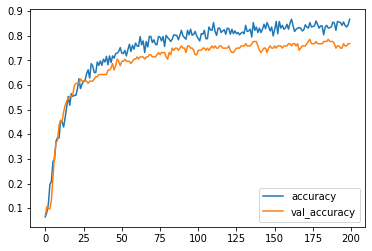

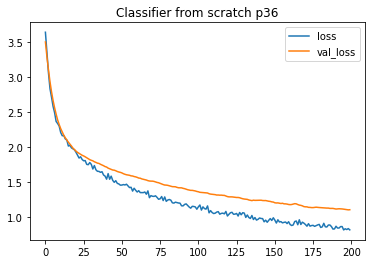

In [28]:
%matplotlib inline
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.title('Classifier from scratch p36')
plt.show()

In [29]:
stop_model = load_model('/tf/data/Quan/tf_models/webcam/amazon_vae_classifier_scratch_model.hdf5')
s_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 0s 327us/step


[1.2269498030012123, 0.7531380653381348]

In [17]:
# retrain source classifier

# Get source classififer (amazon)
s_baseline = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

for i in range(-3,-1):
#     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
    s_topmodel.layers[i].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
s_topmodel.summary()

W1213 11:43:48.749011 140416969307904 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1213 11:43:49.492885 140416969307904 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 18, 18, 736)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 736)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 31)                22847     
_________________________________________________________________
batch_normalization_6 (Batch (None, 31)                124       
_________________________________________________________________
activation_1 (Activation)    (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
_________________________________________________________________


In [23]:
s_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 1s 3ms/step


[4.008128966247686, 0.04184100418410042]

In [18]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transform_features, t_num_labels, batch_size=32, epochs=100,
               validation_data=(val_transform_features, tval_num_labels), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_classifier2_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 1s 3ms/step - loss: 4.1012 - acc: 0.0541 - val_loss: 2.8004 - val_acc: 0.2143
Epoch 2/100
444/444 [==============================] - 0s 466us/step - loss: 3.0769 - acc: 0.1869 - val_loss: 2.3618 - val_acc: 0.3393
Epoch 3/100
444/444 [==============================] - 0s 462us/step - loss: 2.3607 - acc: 0.3536 - val_loss: 2.0638 - val_acc: 0.4643
Epoch 4/100
444/444 [==============================] - 0s 462us/step - loss: 1.9565 - acc: 0.4369 - val_loss: 1.8350 - val_acc: 0.5268
Epoch 5/100
444/444 [==============================] - 0s 466us/step - loss: 1.6868 - acc: 0.5315 - val_loss: 1.6545 - val_acc: 0.6161
Epoch 6/100
444/444 [==============================] - 0s 460us/step - loss: 1.4576 - acc: 0.6149 - val_loss: 1.5154 - val_acc: 0.6518
Epoch 7/100
444/444 [==============================] - 0s 464us/step - loss: 1.3735 - acc: 0.6464 - val_loss: 1.3973 - val_acc: 0.7143
Epoch 8/100

Epoch 61/100
444/444 [==============================] - 0s 462us/step - loss: 0.5113 - acc: 0.8919 - val_loss: 0.6419 - val_acc: 0.8929
Epoch 62/100
444/444 [==============================] - 0s 461us/step - loss: 0.5015 - acc: 0.8986 - val_loss: 0.6324 - val_acc: 0.8929
Epoch 63/100
444/444 [==============================] - 0s 462us/step - loss: 0.5429 - acc: 0.9009 - val_loss: 0.6262 - val_acc: 0.8929
Epoch 64/100
444/444 [==============================] - 0s 463us/step - loss: 0.5201 - acc: 0.8919 - val_loss: 0.6214 - val_acc: 0.8929
Epoch 65/100
444/444 [==============================] - 0s 459us/step - loss: 0.5341 - acc: 0.8671 - val_loss: 0.6245 - val_acc: 0.8839
Epoch 66/100
444/444 [==============================] - 0s 470us/step - loss: 0.5481 - acc: 0.8851 - val_loss: 0.6283 - val_acc: 0.8839
Epoch 67/100
444/444 [==============================] - 0s 478us/step - loss: 0.4693 - acc: 0.9144 - val_loss: 0.6304 - val_acc: 0.8750
Epoch 68/100
444/444 [==========================

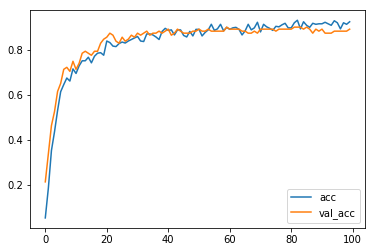

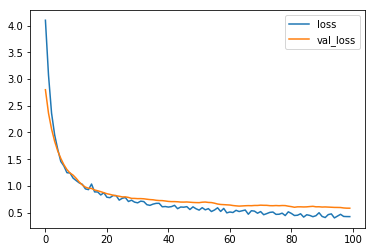

In [19]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [20]:
test_topmodel = load_model('/data/Quan/tf_models/webcam/amazon_classifier2_model.hdf5')
test_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 0s 2ms/step


[0.8929828470222122, 0.7782426790712269]